In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt


from patsy import dmatrices
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_palette('colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
def merge_crawls(crawls, all_urls):
    dfs = []

    for crawl in crawls:

        df = pd.DataFrame(columns=['file_name', 'account_name', 'url_id', 'comment_num', f'{crawl}_comments'])
        temp_list = []

        for account_name in all_urls.keys():
            files = os.listdir(f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{crawl}/{account_name}/')
            for file in files:
                with open(f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{crawl}/{account_name}/{file}', 'r') as f:
                    comments = json.load(f)

                captions = comments[0]

                if len(comments) > 2:
                    user_comment_map = {}
                    for index, val in enumerate(comments):
                        if index == 0:
                            continue

                        if val in user_comment_map.values():
                            continue
                        
                        user_comment_map[val] = comments[index + 1]

                        if comments[index + 1] == comments[-2]:
                            break

                    if 'likes' in comments[-1].lower():
                        likes = comments[-1]
                    else:
                        likes = None

                    for idx, comment in enumerate(user_comment_map.items()):

                        temp = {'file_name': file,
                                'account_name': account_name,
                                'url_id': file.split('_comments')[0],
                                'caption': captions,
                                'likes': likes,
                                'comment_num': idx,
                                f'{crawl}_comments': comment}
                        temp_list.append(temp)
                else:
                    temp = {'file_name': file,
                            'account_name': account_name,
                            'url_id': file.split('_comments')[0],
                            'caption': captions,
                            'likes': None,
                            'comment_num': 0,
                            f'{crawl}_comments': None}
                    temp_list.append(temp)
                

        df = pd.DataFrame(temp_list)
        dfs.append(df)
    
    for df in dfs:
        df.drop(columns=['caption', 'likes', 'url_id'], inplace=True)

    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on=['file_name', 'comment_num', 'account_name'], how='outer')

    return merged_df


def compute_fprops(merged_df, col1, col2):
    unique_files = merged_df['file_name'].unique().tolist()

    for file in unique_files:
        temp_df = merged_df[merged_df['file_name'] == file]
        s1 = temp_df[col1]
        s2 = temp_df[col2]
        fcount = (s1 == s2).value_counts().to_dict().get(False, 0)
        fprop = fcount / temp_df.shape[0]
        merged_df.loc[merged_df['file_name'] == file, 'order_fcount'] = fcount
        merged_df.loc[merged_df['file_name'] == file, 'order_fprop'] = fprop


    for file in unique_files:
        temp_df = merged_df[merged_df['file_name'] == file]
        s1 = set(temp_df[col1])
        s2 = set(temp_df[col2])
        fcount = len(s1.symmetric_difference(s2))
        fprop = fcount / temp_df.shape[0]
        merged_df.loc[merged_df['file_name'] == file, 'no_order_fcount'] = fcount
        merged_df.loc[merged_df['file_name'] == file, 'no_order_fprop'] = fprop


    return merged_df


def get_mat_rank(formula, data):
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    return np.linalg.matrix_rank(X.values) < X.shape[1]


def get_vif(formula, data):
    y, X = dmatrices(formula, data=data, return_type="dataframe")

    vif_df = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

    vif_df.sort_values(by='VIF', ascending=True, inplace=True)
    return vif_df

In [3]:
msnbc_urls = [
    "https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/",
    "https://www.instagram.com/msnbc/reel/DQzvigyiu3R/",
    "https://www.instagram.com/msnbc/reel/DQzaxBeisq2/",
    "https://www.instagram.com/msnbc/reel/DQzOhJyil7B/",
    "https://www.instagram.com/msnbc/reel/DQx_MsXDdqz/",
    "https://www.instagram.com/reel/DQx6d6TDFvD/",
    "https://www.instagram.com/reel/DQxz17nkXAu/",
    "https://www.instagram.com/reel/DQxxwsjEQxy/",
    "https://www.instagram.com/reel/DQxf5uvERD0/",
    "https://www.instagram.com/reel/DQxc21kkqwR/",
]

huffpost_urls = [
    "https://www.instagram.com/huffpost/reel/DQzSuMQARR0/",
    "https://www.instagram.com/huffpost/p/DQxLW-PEns-/",
    "https://www.instagram.com/huffpost/reel/DQxARFuAbt-/",
    "https://www.instagram.com/huffpost/reel/DQw6Qa_kWgY/",
    "https://www.instagram.com/huffpost/reel/DQw5_xHkWod/",
    "https://www.instagram.com/huffpost/reel/DQwbCxQjQNQ/",
    "https://www.instagram.com/huffpost/p/DQu2w59E9t-/",
    "https://www.instagram.com/huffpost/reel/DQvEm2FDCmz/",
    "https://www.instagram.com/huffpost/p/DQuw7U7D322/",
    "https://www.instagram.com/p/DQujjUrk61E/"
]

cnn_urls = [
    "https://www.instagram.com/reel/DQ0VgDjjx7K/",
    "https://www.instagram.com/p/DQ0LWj6jue3/",
    "https://www.instagram.com/reel/DQz7vqJiEUj/",
    "https://www.instagram.com/reel/DQznNr7gp1F/",
    "https://www.instagram.com/reel/DQzgXgPgPmN/",
    "https://www.instagram.com/reel/DQzNYM8ARN3/",
    "https://www.instagram.com/reel/DQzEp0pChCY/",
    "https://www.instagram.com/reel/DQy-AdiCcH_/",
    "https://www.instagram.com/reel/DQyzpQVjga4/",
    "https://www.instagram.com/reel/DQypWvmDoge/"
]

washingtonpost_urls = [
    "https://www.instagram.com/washingtonpost/p/DQ0JgL9DqcC/",
    "https://www.instagram.com/washingtonpost/p/DQz7wRODMr8/",
    "https://www.instagram.com/washingtonpost/p/DQzuD3fFJcu/",
    "https://www.instagram.com/washingtonpost/reel/DQzh-t0DSAJ/",
    "https://www.instagram.com/washingtonpost/reel/DQzgTDHAcKl/",
    "https://www.instagram.com/p/DQzZihPDiQv/",
    "https://www.instagram.com/reel/DQzSo12D1fJ/",
    "https://www.instagram.com/reel/DQzLtq3ARq3/",
    "https://www.instagram.com/p/DQxxk6BDvZh/",
    "https://www.instagram.com/p/DQxqaCpDcHC/"
]

forbes_urls = [
    "https://www.instagram.com/forbes/p/DQ0Ck-lgUxt/",
    "https://www.instagram.com/forbes/p/DQz0444AWAd/",
    "https://www.instagram.com/forbes/p/DQzgP9_gcjC/",
    "https://www.instagram.com/p/DQzUOiGAblX/",
    "https://www.instagram.com/p/DQzLpqJDxMD/",
    "https://www.instagram.com/p/DQzFWzxkT-c/",
    "https://www.instagram.com/p/DQxdypCDPF2/",
    "https://www.instagram.com/p/DQxOpmbkn_b/",
    "https://www.instagram.com/p/DQxFjBJj4gS/",
    "https://www.instagram.com/p/DQxElAzD6aK/"
]

thehill_urls = [
    "https://www.instagram.com/thehill/p/DQzfVDcE3YB/",
    "https://www.instagram.com/thehill/p/DQxg1ufkeqR/",
    "https://www.instagram.com/thehill/reel/DQxViLFEdQ5/",
    "https://www.instagram.com/thehill/p/DQw1LZxEwrn/",
    "https://www.instagram.com/thehill/p/DQwgkZxD2Ug/",
    "https://www.instagram.com/thehill/reel/DQvAK9hEeWU/",
    "https://www.instagram.com/thehill/p/DQunQLokn-7/",
    "https://www.instagram.com/thehill/reel/DQuNa5zEeiR/",
    "https://www.instagram.com/thehill/p/DQt9lxsjumG/",
    "https://www.instagram.com/reel/DQrpC35EXqn/"
]

washingtontimes_urls = [
    "https://www.instagram.com/washtimes/p/DQz0CxJExjr/",
    "https://www.instagram.com/washtimes/p/DQzcWsGkg8C/",
    "https://www.instagram.com/washtimes/p/DQxHICQE_29/",
    "https://www.instagram.com/washtimes/p/DQw_V8sE6ZH/",
    "https://www.instagram.com/washtimes/p/DQw3jz6k0L6/",
    "https://www.instagram.com/washtimes/p/DQwvq-dktiv/",
    "https://www.instagram.com/washtimes/p/DQwn4b2EzCR/",
    "https://www.instagram.com/washtimes/p/DQwgGZ2jQck/",
    "https://www.instagram.com/washtimes/p/DQvCB1iEwBa/",
    "https://www.instagram.com/washtimes/reel/DQu5zA1CL3U/"
]

nypost_urls = [
    "https://www.instagram.com/p/DQ0Jd_SAc4Z/",
    "https://www.instagram.com/p/DQ0GBAngWyx/",
    "https://www.instagram.com/reel/DQ0ETkoDtLN/",
    "https://www.instagram.com/p/DQ0ClEugU1r/",
    "https://www.instagram.com/p/DQz_JRkAWr9/",
    "https://www.instagram.com/reel/DQz9kQIDZOc/",
    "https://www.instagram.com/p/DQz70tPAQTn/",
    "https://www.instagram.com/p/DQz4Y1Xgadc/",
    "https://www.instagram.com/reel/DQz2rWGEkpe/",
    "https://www.instagram.com/p/DQz09vagSe1/"
]

foxnews_urls = [
    "https://www.instagram.com/reel/DQ0V_qAEfwE/",
    "https://www.instagram.com/reel/DQ0UdiODE-2/",
    "https://www.instagram.com/reel/DQ0UNIZD3rv/",
    "https://www.instagram.com/reel/DQ0OfgWAswZ/",
    "https://www.instagram.com/reel/DQ0OAwCk91U/",
    "https://www.instagram.com/reel/DQ0GaXEjofE/",
    "https://www.instagram.com/reel/DQ0ClztkmYz/",
    "https://www.instagram.com/p/DQ0AYUTkvh4/",
    "https://www.instagram.com/p/DQz8ZTUjJ4s/",
    "https://www.instagram.com/reel/DQz8UW2j4TQ/"
]

breitbart_urls = [
    "https://www.instagram.com/p/DQ0P_UtDFLj/",
    "https://www.instagram.com/p/DQ0ImR1DaM0/",
    "https://www.instagram.com/p/DQz28XJkuQV/",
    "https://www.instagram.com/p/DQzkN12CUZQ/",
    "https://www.instagram.com/reel/DQzXuPOkgOo/",
    "https://www.instagram.com/p/DQzR5CjkQxS/",
    "https://www.instagram.com/p/DQzJCenDSPC/",
    "https://www.instagram.com/p/DQy1VfcETEi/",
    "https://www.instagram.com/reel/DQxZ3LCkvgh/",
    "https://www.instagram.com/p/DQxfi8JjVGb/"
]

all_urls = {
    'msnbc': msnbc_urls,
    'huffpost': huffpost_urls,
    'cnn': cnn_urls,
    'washingtonpost': washingtonpost_urls,
    'forbes': forbes_urls,
    'thehill': thehill_urls,
    'washingtontimes': washingtontimes_urls,
    'nypost': nypost_urls,
    'foxnews': foxnews_urls,
    'breitbart': breitbart_urls
}

In [4]:
all_crawls = ['ny_1', 'ny_2', 'texas_1', 'texas_2',
              'male_dem_ny_1', 'male_dem_ny_2', 'male_dem_texas_1', 'male_dem_texas_2',
              'male_rep_ny_1', 'male_rep_ny_2', 'male_rep_texas_1', 'male_rep_texas_2',
              'female_dem_ny_1', 'female_dem_ny_2', 'female_dem_texas_1', 'female_dem_texas_2', 
              'female_rep_ny_1', 'female_rep_ny_2', 'female_rep_texas_1', 'female_rep_texas_2',
              'male_dem_ny_1_100925']

In [5]:
# crawls = ['ny_1', 'ny_2']
crawls = all_crawls
merged_df = merge_crawls(crawls, all_urls)

print(merged_df.duplicated().sum())
merged_df.drop_duplicates(inplace=True)
merged_df.shape

0


(1255, 24)

In [6]:
merged_df = merged_df[merged_df['comment_num']<=9]
merged_df.shape

(884, 24)

In [7]:
for col in merged_df.columns:
    print(col, merged_df[col].isna().sum())

file_name 0
account_name 0
comment_num 0
ny_1_comments 19
ny_2_comments 29
texas_1_comments 69
texas_2_comments 29
male_dem_ny_1_comments 72
male_dem_ny_2_comments 37
male_dem_texas_1_comments 38
male_dem_texas_2_comments 37
male_rep_ny_1_comments 34
male_rep_ny_2_comments 25
male_rep_texas_1_comments 32
male_rep_texas_2_comments 24
female_dem_ny_1_comments 54
female_dem_ny_2_comments 66
female_dem_texas_1_comments 46
female_dem_texas_2_comments 46
female_rep_ny_1_comments 38
female_rep_ny_2_comments 36
female_rep_texas_1_comments 45
female_rep_texas_2_comments 36
male_dem_ny_1_100925_comments 41


In [8]:
urls_topic = pd.read_excel('/Users/brahmaninutakki/saarland/insta-comments/News Sites US.xlsx', sheet_name='Sheet5')
urls_topic['file_name'] = urls_topic['url'].apply(lambda x: x.split('/')[-2] + '_comments.json')
urls_topic

,url,major_topic,file_name
0,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-_comments.json
1,https://www.instagram.com/msnbc/reel/DQzvigyiu3R/,Political,DQzvigyiu3R_comments.json
2,https://www.instagram.com/msnbc/reel/DQzaxBeisq2/,Political,DQzaxBeisq2_comments.json
3,https://www.instagram.com/msnbc/reel/DQzOhJyil7B/,Political,DQzOhJyil7B_comments.json
4,https://www.instagram.com/msnbc/reel/DQx_MsXDdqz/,Political,DQx_MsXDdqz_comments.json
...,...,...,...
95,https://www.instagram.com/p/DQzR5CjkQxS/,Political,DQzR5CjkQxS_comments.json
96,https://www.instagram.com/p/DQzJCenDSPC/,Non-Political,DQzJCenDSPC_comments.json
97,https://www.instagram.com/p/DQy1VfcETEi/,Political,DQy1VfcETEi_comments.json
98,https://www.instagram.com/reel/DQxZ3LCkvgh/,Political,DQxZ3LCkvgh_comments.json


In [ ]:
merged_df = pd.merge(merged_df, urls_topic[['file_name', 'major_topic']], on='file_name', how='left')

In [8]:
# crawls = ['ny_1', 'texas_1']
# temp1 = compute_fprops(merged_df, f'{crawls[0]}_comments', f'{crawls[1]}_comments')
# temp2 = compute_fprops(merged_df, f'{crawls[1]}_comments', f'{crawls[0]}_comments')
# ((temp1 == temp2).all())

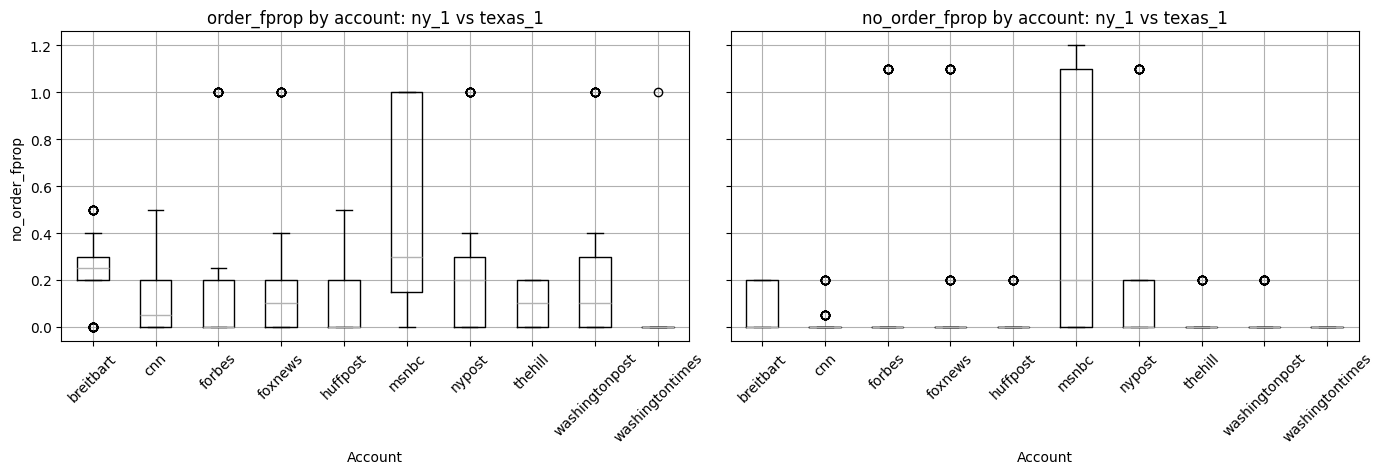

In [9]:
crawls = ['ny_1', 'texas_1']
merged_df = compute_fprops(merged_df, f'{crawls[0]}_comments', f'{crawls[1]}_comments')
# merged_df.groupby('account_name')['order_fprop'].describe()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

merged_df.boxplot(column='order_fprop', by='account_name', ax=axes[0])
axes[0].set_title(f'order_fprop by account: {crawls[0]} vs {crawls[1]}') 
axes[0].set_xlabel('Account')
axes[0].set_ylabel('no_order_fprop')
axes[0].tick_params(axis='x', rotation=45)

merged_df.boxplot(column='no_order_fprop', by='account_name', ax=axes[1])
axes[1].set_title(f'no_order_fprop by account: {crawls[0]} vs {crawls[1]}')
axes[1].set_xlabel('Account')
axes[1].tick_params(axis='x', rotation=45)

fig.suptitle('') 
fig.tight_layout()
plt.show()

In [10]:
# int_crawls = ['ny_1', 'ny_2', 'texas_1', 'texas_2',
#               'male_dem_ny_1', 'male_dem_ny_2', 'male_dem_texas_1', 'male_dem_texas_2',
#               'male_rep_ny_1', 'male_rep_ny_2', 'male_rep_texas_1', 'male_rep_texas_2',
#               'female_dem_ny_1', 'female_dem_ny_2', 'female_dem_texas_1', 'female_dem_texas_2', 
#               'female_rep_ny_1', 'female_rep_ny_2', 'female_rep_texas_1', 'female_rep_texas_2',]
#             #   'male_dem_ny_1_100925']

# reg_df = pd.DataFrame(columns=['account_name', 'location', 'gender', 'ideology', 'no_order_fprop', 'no_order_fcount'])


# temp_list = []
# for crawl1 in tqdm(int_crawls):
#     for crawl2 in int_crawls:

#         if crawl1 == crawl2:
#             continue

#         temp_dict = {}

#         temp_df = compute_fprops(merged_df, f'{crawl1}_comments', f'{crawl2}_comments')
#         temp_df = temp_df[['account_name', 'no_order_fprop', 'no_order_fcount']].drop_duplicates()

#         temp = set()
#         for x in ['ny_1', 'ny_2', 'texas_1', 'texas_2']:
#             if x in crawl1:
#                 temp.add(x)
#                 break
#         for x in ['ny_1', 'ny_2', 'texas_1', 'texas_2']:
#             if x in crawl2:
#                 temp.add(x)
#                 break
#         location = ''
#         if len(temp) > 1:
#             for x in temp:
#                 location = location + x + '_'
#         elif len(temp) == 1:
#             location = temp.pop()
#         elif len(temp) == 0:
#             location = None

#         temp = set()
#         for x in ['female', 'male']:
#             if x in crawl1:
#                 temp.add(x)
#                 break
#         for x in ['female', 'male']:
#             if x in crawl2:
#                 temp.add(x)
#                 break
#         gender = ''
#         if len(temp) > 1:
#             for x in temp:
#                 gender = gender + x + '_'
#         elif len(temp) == 1:
#             gender = temp.pop()
#         elif len(temp) == 0:
#             gender = None

#         temp = set()
#         for x in ['dem', 'rep']:
#             if x in crawl1:
#                 temp.add(x)
#                 break
#         for x in ['dem', 'rep']:
#             if x in crawl2:
#                 temp.add(x)
#                 break
#         ideology = ''
#         if len(temp) > 1:
#             for x in temp:
#                 ideology = ideology + x + '_'
#         elif len(temp) == 1:
#             ideology = temp.pop()
#         elif len(temp) == 0:
#             ideology = None

#         temp_dict['location'] = location
#         temp_dict['gender'] = gender
#         temp_dict['ideology'] = ideology

#         for index, row in temp_df.iterrows():
#             temp_dict['account_name'] = row['account_name']
#             temp_dict['no_order_fprop'] = row['no_order_fprop']
#             temp_dict['no_order_fcount'] = row['no_order_fcount']
#             temp_list.append(temp_dict.copy())


# reg_df = pd.DataFrame(temp_list)        



# int_crawls = ['ny_1', 'ny_2', 'texas_1', 'texas_2',
#               'male_dem_ny_1', 'male_dem_ny_2', 'male_dem_texas_1', 'male_dem_texas_2',
#               'male_rep_ny_1', 'male_rep_ny_2', 'male_rep_texas_1', 'male_rep_texas_2',
#               'female_dem_ny_1', 'female_dem_ny_2', 'female_dem_texas_1', 'female_dem_texas_2', 
#               'female_rep_ny_1', 'female_rep_ny_2', 'female_rep_texas_1', 'female_rep_texas_2',]
#             #   'male_dem_ny_1_100925']

# reg_df = pd.DataFrame(columns=['account_name', 'location', 'gender', 'ideology', 'no_order_fprop', 'no_order_fcount'])


# temp_list = []
# for crawl1 in tqdm(int_crawls):
#     for crawl2 in int_crawls:

#         if crawl1 == crawl2:
#             continue

#         temp_dict = {}

#         temp_df = compute_fprops(merged_df, f'{crawl1}_comments', f'{crawl2}_comments')
#         temp_df = temp_df[['account_name', 'no_order_fprop', 'no_order_fcount']].drop_duplicates()

#         location = ''
#         for x in ['ny_1', 'ny_2', 'texas_1', 'texas_2']:
#             if x in crawl1:
#                 location = location + x
#                 break
#         location = location + '_'
#         for x in ['ny_1', 'ny_2', 'texas_1', 'texas_2']:
#             if x in crawl2:
#                 location = location + x
#                 break

#         gender = ''
#         for x in ['female', 'male']:
#             if x in crawl1:
#                 gender = gender + x
#                 break
#         gender = gender + '_'
#         for x in ['female', 'male']:
#             if x in crawl2:
#                 gender = gender + x
#                 break

#         ideology = ''
#         for x in ['dem', 'rep']:
#             if x in crawl1:
#                 ideology = ideology + x
#                 break
#         ideology = ideology + '_'
#         for x in ['dem', 'rep']:
#             if x in crawl2:
#                 ideology = ideology + x
#                 break

#         temp_dict['location'] = location
#         temp_dict['gender'] = gender
#         temp_dict['ideology'] = ideology

#         for index, row in temp_df.iterrows():
#             temp_dict['account_name'] = row['account_name']
#             temp_dict['no_order_fprop'] = row['no_order_fprop']
#             temp_dict['no_order_fcount'] = row['no_order_fcount']
#             temp_list.append(temp_dict.copy())


# reg_df = pd.DataFrame(temp_list)        

# reg_df.drop_duplicates(inplace=True)
# reg_df.shape

In [10]:
int_crawls = ['ny_1', 'texas_1', 
              'male_dem_ny_1', 'male_dem_texas_1',
              'male_rep_ny_1', 'male_rep_texas_1',
              'female_dem_ny_1', 'female_dem_texas_1',
              'female_rep_ny_1', 'female_rep_texas_1',]
            #   'male_dem_ny_1_100925']

reg_df = pd.DataFrame(columns=['account_name', 'location', 'gender', 'ideology', 'no_order_fprop', 'no_order_fcount'])


temp_list = []
for crawl1 in ['ny_1']:
    for crawl2 in tqdm(int_crawls):

        if crawl1 == crawl2:
            continue

        temp_dict = {}

        temp_df = compute_fprops(merged_df, f'{crawl1}_comments', f'{crawl2}_comments')
        temp_df = temp_df[['account_name', 'no_order_fprop', 'no_order_fcount']].drop_duplicates()

        for index, row in temp_df.iterrows():
            temp_dict['account_name'] = row['account_name']
            temp_dict['no_order_fprop'] = row['no_order_fprop']
            temp_dict['no_order_fcount'] = row['no_order_fcount']
            temp_dict['condition'] = crawl2 
            temp_list.append(temp_dict.copy())


reg_df = pd.DataFrame(temp_list)
print(reg_df.shape)
reg_df.drop_duplicates(inplace=True)
reg_df.shape

100%|██████████| 10/10 [00:00<00:00, 14.67it/s]

(519, 4)


(519, 4)

In [11]:
accounts_data = pd.read_excel('/Users/brahmaninutakki/saarland/insta-comments/News Sites US.xlsx', sheet_name='Sheet3')
accounts_data.head()

,account_name,political_ideology,reporting_quality,credibility,posts,followers,following
0,msnbc,Left,Mixed,Medium,16790,2400000,308
1,huffpost,Left,Mixed,Medium,12119,3300000,708
2,cnn,Center-Left,Mostly Factual,Medium,21936,21700000,289
3,washingtonpost,Center-Left,Mostly Factual,High,24022,7300000,187
4,forbes,Center,Mostly Factual,High,27199,7300000,163


In [12]:
reg_df = pd.merge(reg_df, accounts_data, on='account_name', how='left')
reg_df

,account_name,no_order_fprop,no_order_fcount,condition,political_ideology,reporting_quality,credibility,posts,followers,following
0,foxnews,0.000000,0.0,texas_1,Right,Low,Low,70290,10800000,117
1,forbes,0.000000,0.0,texas_1,Center,Mostly Factual,High,27199,7300000,163
2,nypost,0.000000,0.0,texas_1,Center-Right,Mixed,Medium,53635,2000000,317
3,nypost,0.200000,2.0,texas_1,Center-Right,Mixed,Medium,53635,2000000,317
4,foxnews,0.200000,2.0,texas_1,Right,Low,Low,70290,10800000,117
...,...,...,...,...,...,...,...,...,...,...
514,forbes,0.428571,3.0,female_rep_texas_1,Center,Mostly Factual,High,27199,7300000,163
515,washingtonpost,0.800000,8.0,female_rep_texas_1,Center-Left,Mostly Factual,High,24022,7300000,187
516,cnn,1.000000,10.0,female_rep_texas_1,Center-Left,Mostly Factual,Medium,21936,21700000,289
517,cnn,1.600000,16.0,female_rep_texas_1,Center-Left,Mostly Factual,Medium,21936,21700000,289


In [13]:
reg_df.isna().sum()

account_name          0
no_order_fprop        0
no_order_fcount       0
condition             0
political_ideology    0
reporting_quality     0
credibility           0
posts                 0
followers             0
following             0
dtype: int64

In [18]:
formula = 'no_order_fprop ~ C(account_name) + C(condition) + C(political_ideology) + C(reporting_quality) + C(credibility) + posts + followers + following'
# formula = 'no_order_fprop ~ C(account_name) + C(condition) + C(political_ideology) + C(reporting_quality) + C(credibility) + posts + followers + following'
# get_vif(formula, reg_df)

In [22]:
model = smf.glm(formula=formula, data=reg_df).fit()
model.summary2()

p_raw = model.pvalues

alpha = 0.05
rej, p_bonf, _, _ = multipletests(p_raw, alpha=alpha, method='bonferroni')

results = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p_raw": p_raw,
    "p_bonf": p_bonf,
    "Significant": rej
})

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:                       GLM                     AIC:                   580.5258  
Link Function:               Identity                BIC:                   -3045.4383
Dependent Variable:          no_order_fprop          Log-Likelihood:        -272.26   
Date:                        2025-11-18 23:02        LL-Null:               -317.72   
No. Observations:            519                     Deviance:              86.766    
Df Model:                    17                      Pearson chi2:          86.8      
Df Residuals:                501                     Scale:                 0.17318   
Method:                      IRLS                                                     
--------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                               0.3472   0.0276 12.5696 0.0000  0.2931  0.4014
C(account_name)[T.cnn]                  0.0183   0.0191  0.9591 0.3375 -0.0191  0.0557
C(account_name)[T.forbes]              -0.1617   0.0393 -4.1099 0.0000 -0.2388 -0.0846
C(account_name)[T.foxnews]              0.0739   0.0364  2.0284 0.0425  0.0025  0.1453
C(account_name)[T.huffpost]            -0.0849   0.0281 -3.0200 0.0025 -0.1401 -0.0298
C(account_name)[T.msnbc]                0.1790   0.0279  6.4205 0.0000  0.1243  0.2336
C(account_name)[T.nypost]              -0.0853   0.0181 -4.7218 0.0000 -0.1207 -0.0499
C(account_name)[T.thehill]              0.3156   0.0367  8.5912 0.0000  0.2436  0.3876
C(account_name)[T.washingtonpost]      -0.0022   0.0355 -0.0624 0.9502 -0.0718  0.0673
C(account_name)[T.washingtontimes]      0.1450   0.0392  3.6943 0.0002  0.0681  0.2219
C(condition)[T.female_dem_texas_1]     -0.0465   0.0745 -0.6234 0.5330 -0.1926  0.0996
C(condition)[T.female_rep_ny_1]         0.0591   0.0789  0.7490 0.4539 -0.0956  0.2138
C(condition)[T.female_rep_texas_1]      0.0472   0.0749  0.6308 0.5282 -0.0995  0.1940
C(condition)[T.male_dem_ny_1]          -0.0570   0.0770 -0.7403 0.4591 -0.2080  0.0939
C(condition)[T.male_dem_texas_1]        0.0281   0.0751  0.3737 0.7086 -0.1192  0.1754
C(condition)[T.male_rep_ny_1]          -0.0890   0.0743 -1.1982 0.2308 -0.2346  0.0566
C(condition)[T.male_rep_texas_1]       -0.0629   0.0743 -0.8470 0.3970 -0.2084  0.0826
C(condition)[T.texas_1]                -0.4221   0.0981 -4.3045 0.0000 -0.6143 -0.2299
C(political_ideology)[T.Center-Left]    0.0161   0.0301  0.5342 0.5932 -0.0429  0.0751
C(political_ideology)[T.Center-Right]   0.0596   0.0342  1.7460 0.0808 -0.0073  0.1266
C(political_ideology)[T.Left]           0.0940   0.0294  3.2010 0.0014  0.0365  0.1516
C(political_ideology)[T.Right]          0.0236   0.0352  0.6700 0.5029 -0.0454  0.0926
C(reporting_quality)[T.Mixed]           0.1034   0.0280  3.6951 0.0002  0.0485  0.1582
C(reporting_quality)[T.Mostly Factual]  0.1700   0.0248  6.8465 0.0000  0.1213  0.2187
C(credibility)[T.Low]                   0.1686   0.0246  6.8440 0.0000  0.1203  0.2168
C(credibility)[T.Medium]                0.0270   0.0212  1.2741 0.2026 -0.0145  0.0685
posts                                   0.0000   0.0000  0.4304 0.6669 -0.0000  0.0000
followers                               0.0000   0.0000  3.4075 0.0007  0.0000  0.0000
following                               0.0001   0.0001  0.6573 0.5110 -0.0002  0.0003
======================================================================================

"""

In [20]:
results[results['Significant'] == True]

,coef,std_err,t,p_raw,p_bonf,Significant
Intercept,3.472482e-01,2.762604e-02,12.569598,3.102977e-36,8.998634e-35,True
C(account_name)[T.forbes],-1.616930e-01,3.934214e-02,-4.109918,3.957991e-05,1.147817e-03,True
C(account_name)[T.msnbc],1.789649e-01,2.787386e-02,6.420528,1.358026e-10,3.938275e-09,True
C(account_name)[T.nypost],-8.531336e-02,1.806793e-02,-4.721812,2.337531e-06,6.778841e-05,True
C(account_name)[T.thehill],3.156036e-01,3.673549e-02,8.591243,8.603333e-18,2.494967e-16,True
C(account_name)[T.washingtontimes],1.449575e-01,3.923858e-02,3.694261,2.205275e-04,6.395297e-03,True
C(condition)[T.texas_1],-4.221223e-01,9.806556e-02,-4.304491,1.673700e-05,4.853729e-04,True
C(political_ideology)[T.Left],9.401971e-02,2.937238e-02,3.200957,1.369720e-03,3.972188e-02,True
C(reporting_quality)[T.Mixed],1.033520e-01,2.796983e-02,3.695126,2.197781e-04,6.373565e-03,True
C(reporting_quality)[T.Mostly Factual],1.699891e-01,2.482851e-02,6.846529,7.566358e-12,2.194244e-10,True


In [216]:
int_crawls = ['ny_1', 'ny_2', 'texas_1', 'texas_2',
              'male_dem_ny_1', 'male_dem_ny_2', 'male_dem_texas_1', 'male_dem_texas_2',
              'male_rep_ny_1', 'male_rep_ny_2', 'male_rep_texas_1', 'male_rep_texas_2',
              'female_dem_ny_1', 'female_dem_ny_2', 'female_dem_texas_1', 'female_dem_texas_2', 
              'female_rep_ny_1', 'female_rep_ny_2', 'female_rep_texas_1', 'female_rep_texas_2',
              'male_dem_ny_1_100925']

account_name = 'breitbart'
url = 'https://www.instagram.com/p/DQxfi8JjVGb/'
url_id = url.split('/')[-2]
unique_comments = set()

for col in int_crawls:
    temp_df = merged_df[(merged_df['account_name'] == account_name) & (merged_df['file_name'] == f'{url_id}_comments.json')]

    for x in temp_df[f'{col}_comments'].tolist():
        unique_comments.add(x)

In [217]:
for x in unique_comments:
    print(x)

('attilawbodnar', 'Abolish welfare')
('maxse01', 'As long as we can audit the recipients')
('johnanderson5478', 'Make everyone re-certify in person.')
('rdfl.18', 'Snap, ebt and section 8 needs to audited asap')
('the_other_l_8055', 'How does a district court force the government to fund something?')
('somedude12a', 'I’m sorry but when judges become politicians we got problems')
('13shodriver', "That'll be fine... Until next month when those funds don't exist. As it is, there's no 'reserve' SNAP fund. These monies came from elsewhere and I'm interested as to where- since no one in Congress seems to be telling us.")
('pat_ethington', 'Cut all of them off and rework the entire system.')
('meandjaxs', 'This is ridiculous! We authorized to give Snap to people who are most likely NOT US Citizens and choose not to work, but we don’t authorize paychecks for the actual federal employees.')
('peter501nj', 'It’s time for all snap receivers to re apply for the program with proof of eligibility')


In [209]:
merged_df['account_name'].value_counts()

account_name
msnbc              107
foxnews            100
breitbart          100
washingtonpost     100
cnn                100
thehill            100
nypost              88
huffpost            88
forbes              79
washingtontimes     22
Name: count, dtype: int64

*** collect data from 2 other accounts ***
* add gender as a var
* add account details as a var
* annotate posts
* do post level analysis with yes/no as label.
* apply bernoullis
* do gender ideology diff nicely
* also do chronological shit